In this example, we will use Naive Bayes Classifier for Anomaly Detection. We will use a sample pcap file from a honeypot as our training and test dataset. The script will extract features like src_ip, dst_ip, protocol and packet size. Lastly, we will evaluate the model by visualizing the classification and the decision boundry.

The activity has a total of  Steps.

Step 1: Install and import the libs.

In [1]:
%pip install -U scikit-learn
%pip install scapy
import pandas as pd
from scapy.all import rdpcap, IP
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444330 sha256=b40ada3f0bbe2b22ed14a0c5e451cf0a8cdd30fc142dd45b6aa63a3fd75a09bf
  Stored in directory: /root/.cache/pip/wheels/82/b7/03/8344d8cf6695624746311bc0d389e9d05535ca83c35f90241d
Successfully built scapy


Step 2: The function below extracts the features like source IP, destination IP, protocol and packet_size from the packets in the pcap file.

In [2]:
def extract_features(packet):
    # Extract relevant features from the packet
    src_ip = packet[IP].src if IP in packet else 'Unknown'
    dst_ip = packet[IP].dst if IP in packet else 'Unknown'
    protocol = packet.sprintf("%IP.proto%") if IP in packet else 'Unknown'
    packet_size = len(packet)

    return {'Source_IP': src_ip, 'Destination_IP': dst_ip, 'Protocol': protocol, 'Packet_Size': packet_size}



Step 3: Load the pcap file and extract features using the function above. Next, create a dataframe with the extracted features.

In [3]:
# Load pcap file
#pcap_file = ''
pcap_file = '/content/sample_data/1108-1208.pcap'
packets = rdpcap(pcap_file)

# Extract features from each packet
data = [extract_features(packet) for packet in packets]

# Create a DataFrame from the extracted features
df = pd.DataFrame(data)

Step 4: Encode the categorial variables (features) to make it all a compatible datatype for training.

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [4]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Source_IP', 'Destination_IP', 'Protocol'], drop_first=True)

Step 5: Assign the labels normal and anomalous for the traffic and classification. In this example, we will assume all packets with abnormal packet size as a characteristic for anomalous labelling.

In [5]:
# Assign labels (0: Normal, 1: Anomalous)
df['Anomalous'] = 0

# Assume packets with abnormal characteristics as anomalous
df.loc[df['Packet_Size'] > df['Packet_Size'].mean() + 2 * df['Packet_Size'].std(), 'Anomalous'] = 1

Step 6: Split the dataset into features set and target set. Further, split the data into training and test dataset.

In [6]:
# Split the data into features and target
X = df.drop('Anomalous', axis=1)
y = df['Anomalous']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 7: Create a NB classifier and train the model.

In [7]:
# Create a Naive Bayes classifier
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

GaussianNB()

Step 8: Next, we make predictions on the test dataset

In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)

Step 9: Evaluate the model for accuracy.

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

# Print the total number of anomalies and non-anomalies
total_samples = len(df)
total_anomalies = df['Anomalous'].sum()
total_non_anomalies = total_samples - total_anomalies

print(f"Total samples:{total_samples}")
print(f"Total Anomalies Identified: {total_anomalies}")
print(f"Total Non-Anomalies: {total_non_anomalies}")

Accuracy: 0.984375
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1500
           1       0.92      0.97      0.94       228

    accuracy                           0.98      1728
   macro avg       0.96      0.98      0.97      1728
weighted avg       0.98      0.98      0.98      1728

Total samples:8640
Total Anomalies Identified: 1173
Total Non-Anomalies: 7467


Step 10: Visualize the Decision Boundry for the prediction of the trained model.

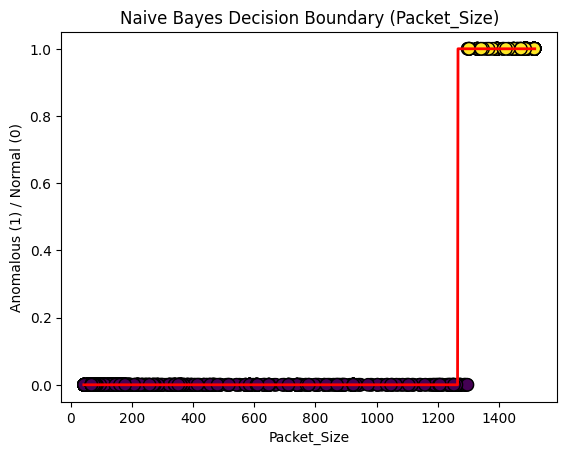

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ... (previous code remains unchanged)

# Select only the 'Packet_Size' feature for plotting
X_packet_size = X['Packet_Size'].values.reshape(-1, 1)

# Train the Naive Bayes classifier on the 'Packet_Size' feature
model_packet_size = GaussianNB()
model_packet_size.fit(X_packet_size, y)

# Plot decision boundary
x_min, x_max = X_packet_size.min() - 1, X_packet_size.max() + 1
xx = np.linspace(x_min, x_max, 1000).reshape(-1, 1)
yy = model_packet_size.predict(xx)

plt.scatter(X_packet_size, y, c=y, cmap='viridis', edgecolors='k', marker='o', s=80)
plt.plot(xx, yy, color='red', linewidth=2)

plt.title('Naive Bayes Decision Boundary (Packet_Size)')
plt.xlabel('Packet_Size')
plt.ylabel('Anomalous (1) / Normal (0)')

plt.show()